### **Logistic Regression Assumptions**

- Logistic Regression model requires the dependent variable to be binary, multinomial or ordinal in nature.

- It requires the observations to be independent of each other. So, the observations should not come from repeated measurements.

- Logistic Regression algorithm requires little or no multicollinearity among the independent variables. It means that the independent variables should not be too highly correlated with each other.

- Logistic Regression model assumes linearity of independent variables and log odds.

- The success of Logistic Regression model depends on the sample sizes. Typically, it requires a large sample size to achieve the high accuracy.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.metrics import (roc_auc_score,brier_score_loss,
    roc_curve, auc, accuracy_score, f1_score,precision_recall_fscore_support,
    confusion_matrix, classification_report,average_precision_score, precision_recall_curve
)
from patsy import dmatrices
from sklearn.dummy import DummyClassifier
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib                                       # for saving artifacts


In [2]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'stix',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 1.0,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
})

In [3]:
def metrics_at_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)   # [[TN, FP],[FN, TP]]
    TN, FP, FN, TP = cm.ravel()
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    acc  = accuracy_score(y_true, y_pred)
    return {'threshold': thr, 'TP':TP,'TN':TN,'FP':FP,'FN':FN,
            'sensitivity':sens, 'specificity':spec, 'accuracy':acc}

SEED = 1234
np.random.seed(SEED)

In [4]:
# 0. Setup
outdir = r"C:\Users\tm1621\Desktop\Oncology Project"
os.makedirs(outdir, exist_ok=True)
r_dir  = r"C:\Users\tm1621\Desktop\Oncology Project\R Results"

# 1. LOAD DATA FILES
maf_file = os.path.join(outdir, "cohortMAF.2025-05-25.maf")
clinical_file = r"C:\Users\tm1621\Desktop\Oncology Project\clinical.cohort.2025-05-25\clinical.tsv"

maf = pd.read_csv(maf_file, sep="\t", comment="#", low_memory=False)
clinical = pd.read_csv(clinical_file, sep="\t", low_memory=False)

In [5]:
# 2 & 3. FEATURE AGGREGATION & CLEANING
drivers = ["KRAS", "TP53", "APC", "SMAD4"]
vc_types = ["Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins"]

# a) driver flags like data.table::dcast
maf_drivers = maf[
    maf["Hugo_Symbol"].isin(drivers) &
    maf["Variant_Classification"].isin(vc_types)
]
flags = (
    maf_drivers
    .groupby(["Tumor_Sample_Barcode", "Hugo_Symbol"])
    .size()
    .unstack(fill_value=0)                 # 0 = no hits
    .map(lambda x: 1 if x > 0 else 0) # convert to binary
    .reset_index()
)

# b) tumor mutational burden
tmb = (
    maf[maf["Variant_Classification"].isin(vc_types)]
    .groupby("Tumor_Sample_Barcode")
    .size()
    .reset_index(name="Mutation_Count")
)

# c) Merge and join clinical
flags["Sample_ID"] = flags["Tumor_Sample_Barcode"].str[:12]
tmb["Sample_ID"] = tmb["Tumor_Sample_Barcode"].str[:12]
feature_table = (
    flags
    .merge(tmb, on=["Tumor_Sample_Barcode", "Sample_ID"], how="outer")
    .merge(clinical,
           left_on="Sample_ID",
           right_on="cases.submitter_id",
           how="left")
)

feature_table['Age'] = pd.to_numeric(
    feature_table['demographic.age_at_index'],
    errors='coerce'
)

# b) Pull out the exact same columns into model_data
model_data = feature_table[[
    'KRAS','TP53','APC','SMAD4','Mutation_Count',
    'Age',
    'diagnoses.ajcc_pathologic_stage',
    'demographic.vital_status',
    'diagnoses.days_to_last_follow_up'
]].copy()

# c) Rename to match R
model_data.columns = [
    'KRAS','TP53','APC','SMAD4','Mutation_Count',
    'Age','Stage','Outcome','FollowUp']


# d) Coerce Age to numeric (like R’s as.numeric())
model_data['Age'] = pd.to_numeric(model_data['Age'])


#  Clean up FollowUp placeholders (strip stray quotes, if any) 
#  But do NOT convert to numeric yet!
model_data['FollowUp'] = model_data['FollowUp'].astype(str)

model_data['Stage']   = model_data['Stage'].astype('category')
model_data['Outcome'] = model_data['Outcome'].astype('category')

# --- One‑pass dropna() exactly like R’s na.omit() ---
print("Rows before dropna:", model_data.shape[0])
model_data = model_data.dropna()
print("Rows after  dropna:", model_data.shape[0])

Rows before dropna: 2750
Rows after  dropna: 2106


In [6]:
model_data.to_csv(os.path.join(outdir, 'model_data_cleaned.csv'), index=False)
figdir =  r"C:\Users\tm1621\Desktop\Oncology Project\Python Results\Logistic_Regression"

In [7]:
# --- enforce ints on the truly-numeric columns ---
int_cols = ['KRAS','TP53','APC','SMAD4','Mutation_Count','Age']
model_data[int_cols] = model_data[int_cols].astype('int64')


In [8]:
r_path = r"C:\Users\tm1621\Desktop\Oncology Project\R Results\model_data_cleaned.csv"
py_path = r"C:\Users\tm1621\Desktop\Oncology Project\model_data_cleaned.csv"


df_r = pd.read_csv(r_path,   keep_default_na=False)
df_py = pd.read_csv(py_path, keep_default_na=False)
# 2. Shape check
print(f"R shape:      {df_r.shape}")
print(f"Python shape: {df_py.shape}")
assert df_r.shape == df_py.shape, "Row/column counts differ!"

# Element‑wise mismatch counts
# Note: this treats NaN==NaN as equal
mismatches = (df_r != df_py) & ~(df_r.isna() & df_py.isna())
mismatch_counts = mismatches.sum().loc[lambda s: s > 0]
if mismatch_counts.empty:
    print("✅ No element‑wise mismatches across any column.")
else:
    print("❌ Mismatches found:")
    print(mismatch_counts)

# 4. Data‑type concordance
print("\nR dtypes:")
print(df_r.dtypes)
print("\nPython dtypes:")
print(df_py.dtypes)

R shape:      (2106, 9)
Python shape: (2106, 9)
✅ No element‑wise mismatches across any column.

R dtypes:
KRAS               int64
TP53               int64
APC                int64
SMAD4              int64
Mutation_Count     int64
Age                int64
Stage             object
Outcome           object
FollowUp          object
dtype: object

Python dtypes:
KRAS              float64
TP53              float64
APC               float64
SMAD4             float64
Mutation_Count      int64
Age               float64
Stage              object
Outcome            object
FollowUp           object
dtype: object


In [9]:
df_r  = pd.read_csv(r_path)
df_py = pd.read_csv(py_path)

for col in ['Stage', 'Outcome']:
    r_levels  = set(df_r[col].dropna().unique())
    py_levels = set(df_py[col].dropna().unique())
    print(f"\nColumn: {col}")
    print(f"  R levels   ({len(r_levels)}): {sorted(r_levels)}")
    print(f"  Py levels  ({len(py_levels)}): {sorted(py_levels)}")
    if r_levels == py_levels:
        print("  ✅ Levels match exactly.")
    else:
        diff1 = r_levels - py_levels
        diff2 = py_levels - r_levels
        if diff1: print(f"  In R only: {sorted(diff1)}")
        if diff2: print(f"  In Py only: {sorted(diff2)}")


Column: Stage
  R levels   (14): ["'--", 'Stage I', 'Stage IA', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV', 'Stage IVA', 'Stage IVB']
  Py levels  (14): ["'--", 'Stage I', 'Stage IA', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV', 'Stage IVA', 'Stage IVB']
  ✅ Levels match exactly.

Column: Outcome
  R levels   (2): ['Alive', 'Dead']
  Py levels  (2): ['Alive', 'Dead']
  ✅ Levels match exactly.


### ***~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~***

### ***Actual Log Regression***

In [10]:
train, test = train_test_split(
    model_data,
    train_size=0.7,
    random_state=SEED,
    stratify=model_data["Outcome"],
    shuffle=True
)
train["Y"] = (train.Outcome=="Dead").astype(int)
test ["Y"] = (test.Outcome =="Dead").astype(int)

# predictor list
feature_cols = ['KRAS','TP53','APC','SMAD4','Mutation_Count','Age','Stage']

In [11]:
# ─── statsmodels GLM ────────────────────────────────────────────────────────
formula = "Y ~ KRAS + TP53 + APC + SMAD4 + Mutation_Count + Age + Stage"
glm = smf.glm(formula, data=train, family=sm.families.Binomial()).fit()
print(glm.summary())

params = glm.params
conf   = glm.conf_int(alpha=0.05); conf.columns = ["2.5%", "97.5%"]
or_df = pd.DataFrame({
    "OR": np.exp(params),
    "CI lower": np.exp(conf["2.5%"]),
    "CI upper": np.exp(conf["97.5%"]),
    "p-value": glm.pvalues
})
or_df.to_csv(os.path.join(outdir,"glm_odds_ratios_with_ci.csv"), index=True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                 1474
Model:                            GLM   Df Residuals:                     1454
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -701.71
Date:                Tue, 02 Sep 2025   Deviance:                       1403.4
Time:                        10:24:14   Pearson chi2:                 1.47e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.1541
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.4743    

c:\Users\tm1621\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


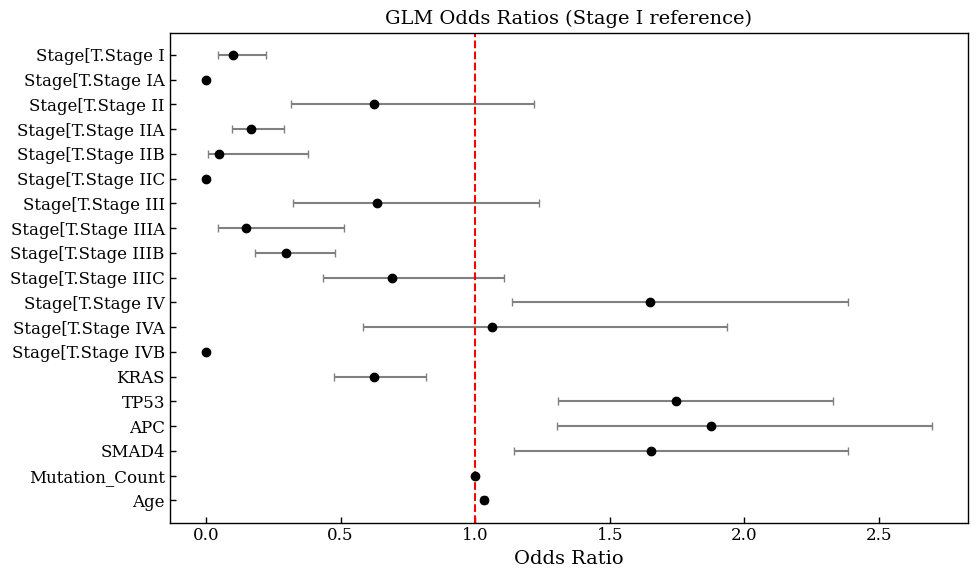

In [12]:
stage_order = ["Stage I","Stage IA","Stage IB","Stage IC",
               "Stage II","Stage IIA","Stage IIB","Stage IIC",
               "Stage III","Stage IIIA","Stage IIIB","Stage IIIC",
               "Stage IV","Stage IVA","Stage IVB"]

plot_df = or_df.drop(index="Intercept").copy()
plot_df.index = plot_df.index.str.replace(r"C\(Stage, Treatment\(reference='Stage I'\)\)\[T\.", "Stage ", regex=True).str.replace("]", "", regex=True)

plt.figure(figsize=(10,6))
y_pos = np.arange(len(plot_df))
plt.errorbar(plot_df["OR"], y_pos,
             xerr=[plot_df["OR"]-plot_df["CI lower"], plot_df["CI upper"]-plot_df["OR"]],
             fmt="o", color="black", ecolor="gray", capsize=3)
plt.axvline(1, color="red", linestyle="--")
plt.yticks(y_pos, plot_df.index)
plt.xlabel("Odds Ratio")
plt.title("GLM Odds Ratios (Stage I reference)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(figdir,"forestplot_or.png"), dpi=200, bbox_inches="tight")
plt.show()

In [13]:
# -------------------------
# sklearn pipeline (tuned + calibrated)
# -------------------------
X_train, y_train = train[feature_cols], train["Y"]
X_test,  y_test  = test [feature_cols], test ["Y"]
dummy = DummyClassifier(strategy="stratified", random_state=1234).fit(X_train, y_train)
print("Dummy ROC-AUC:", roc_auc_score(y_test, dummy.predict_proba(X_test)[:,1]))
print("Prevalence (Dead rate):", y_test.mean())

Dummy ROC-AUC: 0.5223131076097888
Prevalence (Dead rate): 0.24841772151898733


In [14]:
stage_levels = list(train["Stage"].cat.categories) if hasattr(train["Stage"], "cat") \
               else sorted(train["Stage"].unique())

preproc = ColumnTransformer([
    ("scale", StandardScaler(),      ["Mutation_Count","Age"]),
    ("ohe",   OneHotEncoder(drop="first", handle_unknown="ignore"), ["Stage"])      # prevents test-time errors when a Stage appears in test but not in train
], remainder="passthrough")     


pipe = Pipeline([
    ("prep", preproc),
    ("clf",  LogisticRegression(
         solver    = "saga",
         class_weight = "balanced",   
         max_iter  = 2000,
         tol       = 1e-3,
         random_state = 1234,
         n_jobs       = -1     
    ))
])

In [15]:
n_dead  = (model_data["Outcome"]=="Dead").sum()
n_total = len(model_data)
print(f"Dead: {n_dead} | Alive: {n_total - n_dead} | Event rate: {n_dead/n_total:.1%}")

Dead: 522 | Alive: 1584 | Event rate: 24.8%


In [16]:
k_min = 5
max_folds = n_dead // k_min
#n_splits = max(3, min(max_folds, 10))
n_splits = 5
# get an unbiased estimate of generalization AUC while tuning C and penalty
param_grid = {
    "clf__penalty":      ["l1", "l2"],
    "clf__C":            np.logspace(-4, 4, 9),
    "clf__class_weight": [None, "balanced", {0:1, 1:2}, {0:1, 1:5}]
}

inner_cv  = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
outer_cv  = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

gs = GridSearchCV(
    pipe, param_grid, cv=inner_cv,
    scoring="roc_auc", n_jobs=-1, verbose=1
)
# nested CV estimate
nested_scores = cross_val_score(
    gs, X_train, y_train,
    cv=outer_cv, scoring="roc_auc", n_jobs=-1
)
print(f"Nested ROC‑AUC: {nested_scores.mean():.3f} ± {nested_scores.std():.3f}")

Nested ROC‑AUC: 0.738 ± 0.033


In [17]:
# fit on full training set with inner CV tuning
gs.fit(X_train, y_train)
best_mod = gs.best_estimator_
y_prob_uncal = best_mod.predict_proba(X_test)[:, 1]
brier_uncal = brier_score_loss(y_test, y_prob_uncal)
auc_uncal   = roc_auc_score(y_test, y_prob_uncal)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [18]:
print("\n>>> Best hyper‑parameters")
for k,v in gs.best_params_.items():
    print(f"    {k}: {v}")
print(f"    inner‑CV ROC‑AUC: {gs.best_score_:.3f}")


>>> Best hyper‑parameters
    clf__C: 1000.0
    clf__class_weight: {0: 1, 1: 2}
    clf__penalty: l2
    inner‑CV ROC‑AUC: 0.738


In [19]:
y_prob_uncal = best_mod.predict_proba(X_test)[:,1]
brier_uncal  = brier_score_loss(y_test, y_prob_uncal)
auc_uncal    = roc_auc_score(y_test, y_prob_uncal)

In [20]:
# Calibrate only the classifier (keep the preprocessor fixed)
preproc_fitted = best_mod.named_steps['prep']
clf_fitted     = best_mod.named_steps['clf']

X_train_trans = preproc_fitted.transform(X_train)
X_test_trans  = preproc_fitted.transform(X_test)

cal_model = CalibratedClassifierCV(estimator=clf_fitted, method='isotonic',
                                   cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED))
cal_model.fit(X_train_trans, y_train)

y_prob_cal = cal_model.predict_proba(X_test_trans)[:,1]
brier_cal  = brier_score_loss(y_test, y_prob_cal)
auc_cal    = roc_auc_score(y_test, y_prob_cal)

print("=== Performance Comparison ===")
print(f"Uncalibrated AUC : {auc_uncal:.3f} | Brier: {brier_uncal:.4f}")
print(f"Calibrated   AUC : {auc_cal:.3f} | Brier: {brier_cal:.4f}")

=== Performance Comparison ===
Uncalibrated AUC : 0.742 | Brier: 0.1777
Calibrated   AUC : 0.748 | Brier: 0.1551


- ROC AUC ≈ 0.74–0.75 → moderate discrimination.
- PR AUC ≈ 0.52 → reflects imbalance (Dead class is rarer).
- Calibration slightly improves both AUC and Brier score → calibrated outputs are more reliable for probability-based decisions.

In [21]:
# PR curves
ap_uncal = average_precision_score(y_test, y_prob_uncal)
ap_cal   = average_precision_score(y_test, y_prob_cal)

prec_u, rec_u, _ = precision_recall_curve(y_test, y_prob_uncal)
prec_c, rec_c, _ = precision_recall_curve(y_test, y_prob_cal)

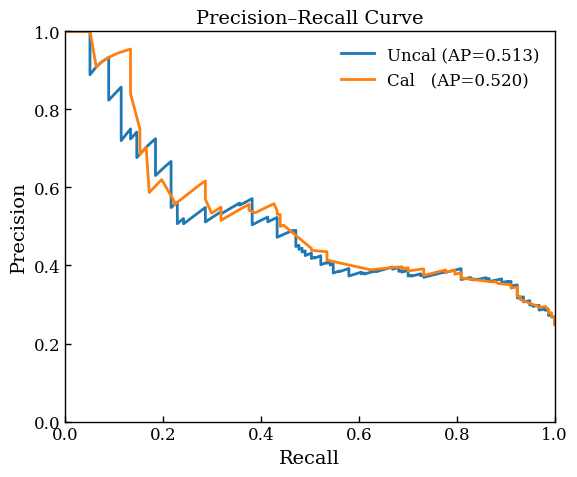

In [22]:
plt.figure(figsize=(6,5))
plt.plot(rec_u, prec_u, label=f"Uncal (AP={ap_uncal:.3f})", lw=2)
plt.plot(rec_c, prec_c, label=f"Cal   (AP={ap_cal:.3f})", lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
plt.xlim(0,1); plt.ylim(0,1)
plt.legend(frameon=False) 
plt.tight_layout()
plt.savefig(os.path.join(figdir,"pr_curve.png"), dpi=200, bbox_inches="tight")
plt.show()

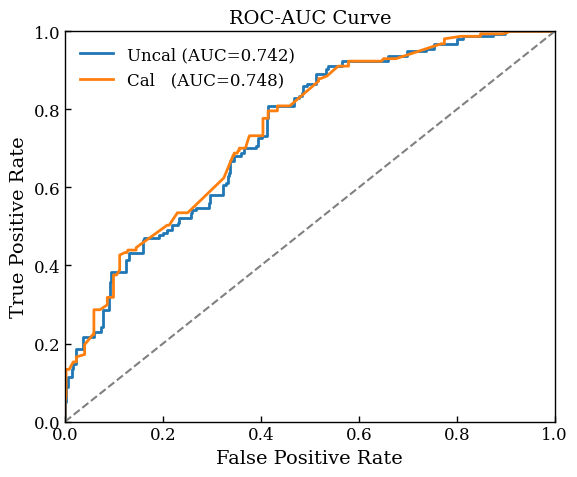

In [23]:
# ROC curves
fpr_uncal, tpr_uncal, _ = roc_curve(y_test, y_prob_uncal)
fpr_cal,   tpr_cal,   _ = roc_curve(y_test, y_prob_cal)

plt.figure(figsize=(6,5))
plt.plot(fpr_uncal, tpr_uncal, label=f"Uncal (AUC={auc_uncal:.3f})", lw=2)
plt.plot(fpr_cal,   tpr_cal,   label=f"Cal   (AUC={auc_cal:.3f})",   lw=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(frameon=False); plt.tight_layout()
plt.savefig(os.path.join(figdir,"roc_before_after.png"), dpi=200, bbox_inches="tight")
plt.show()

In [24]:
pt_uncal_x, pt_uncal_y = calibration_curve(y_test, y_prob_uncal, n_bins=10, strategy="quantile")
pt_cal_x,   pt_cal_y   = calibration_curve(y_test, y_prob_cal,   n_bins=10, strategy="quantile")

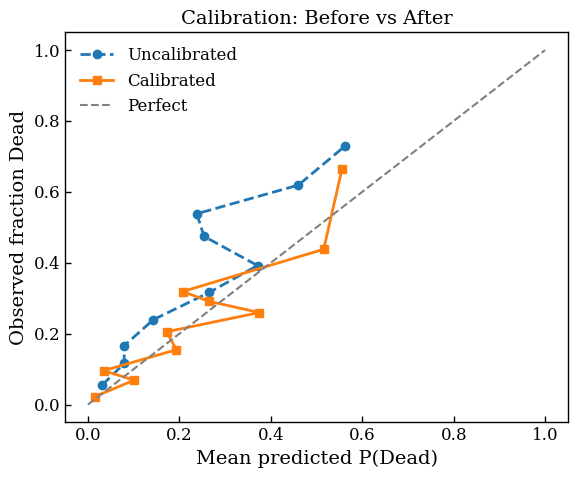

In [25]:
plt.figure(figsize=(6,5))
plt.plot(pt_uncal_x, pt_uncal_y, "o--", label="Uncalibrated", lw=2)
plt.plot(pt_cal_x,   pt_cal_y,   "s-",  label="Calibrated",   lw=2)
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.xlabel("Mean predicted P(Dead)"); plt.ylabel("Observed fraction Dead")
plt.title("Calibration: Before vs After"); plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(figdir,"calibration_before_after.png"), dpi=200, bbox_inches="tight")
plt.show()

In [26]:
thresholds = np.linspace(0.1, 0.9, 15)
thresholds = np.sort(np.unique(thresholds))
print("Thresholds to evaluate:", thresholds)

Thresholds to evaluate: [0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5        0.55714286 0.61428571 0.67142857 0.72857143
 0.78571429 0.84285714 0.9       ]


In [27]:
records = []
for t in thresholds:
    y_pred = (y_prob_cal >= t).astype(int)
    p, r, f1, sup = precision_recall_fscore_support(y_test, y_pred, labels=[0,1], zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    records.append({
        "Threshold": t,
        "Accuracy": (tp + tn) / (tp + tn + fp + fn),
        "Precision_Alive": p[0], "Recall_Alive": r[0], "F1_Alive": f1[0], "Support_Alive": sup[0],
        "Precision_Dead":  p[1], "Recall_Dead":  r[1], "F1_Dead":  f1[1], "Support_Dead":  sup[1],
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    })
report_df = pd.DataFrame.from_records(records)
report_df["MacroF1"] = (report_df["F1_Alive"] + report_df["F1_Dead"]) / 2
n_alive = report_df["Support_Alive"].iloc[0]
n_dead  = report_df["Support_Dead"].iloc[0]
n_total = n_alive + n_dead
report_df["WeightedF1"] = (report_df["F1_Alive"]*n_alive + report_df["F1_Dead"]*n_dead) / n_total
print("\nPer-threshold summary:\n", report_df.round(3).to_string(index=False))
report_df.to_csv(os.path.join(outdir,"per_threshold_metrics.csv"), index=False)


Per-threshold summary:
  Threshold  Accuracy  Precision_Alive  Recall_Alive  F1_Alive  Support_Alive  Precision_Dead  Recall_Dead  F1_Dead  Support_Dead  TN  FP  FN  TP  MacroF1  WeightedF1
     0.100     0.506            0.936         0.368     0.529            475           0.326        0.924    0.482           157 175 300  12 145    0.505       0.517
     0.157     0.570            0.925         0.465     0.619            475           0.354        0.885    0.505           157 221 254  18 139    0.562       0.591
     0.214     0.634            0.896         0.581     0.705            475           0.386        0.796    0.520           157 276 199  32 125    0.612       0.659
     0.271     0.658            0.865         0.646     0.740            475           0.394        0.694    0.502           157 307 168  48 109    0.621       0.681
     0.329     0.763            0.824         0.869     0.846            475           0.527        0.439    0.479           157 413  62  88  69 

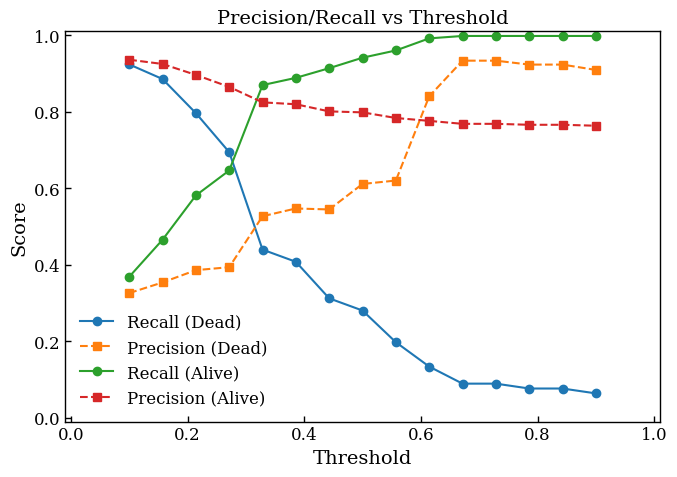

In [28]:
plt.figure(figsize=(7,5))
plt.plot(report_df["Threshold"], report_df["Recall_Dead"],     "o-",  label="Recall (Dead)")
plt.plot(report_df["Threshold"], report_df["Precision_Dead"],  "s--", label="Precision (Dead)")
plt.plot(report_df["Threshold"], report_df["Recall_Alive"],    "o-",  label="Recall (Alive)")
plt.plot(report_df["Threshold"], report_df["Precision_Alive"], "s--", label="Precision (Alive)")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.ylim(-0.01,1.01); plt.xlim(-0.01,1.01)
plt.title("Precision/Recall vs Threshold"); plt.legend(frameon=False)
plt.tight_layout(); plt.savefig(os.path.join(figdir,"precision_recall_vs_threshold.png"), dpi=200, bbox_inches="tight"); plt.show()

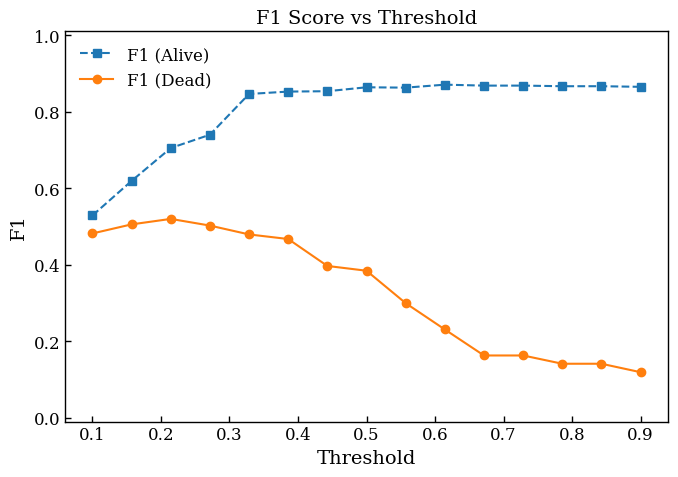

In [29]:
# F1 vs threshold (+ macro/weighted)
plt.figure(figsize=(7,5))
plt.plot(report_df["Threshold"], report_df["F1_Alive"], "s--", label="F1 (Alive)")
plt.plot(report_df["Threshold"], report_df["F1_Dead"],  "o-",  label="F1 (Dead)")
plt.xlabel("Threshold"); plt.ylabel("F1"); plt.ylim(-0.01,1.01)
plt.title("F1 Score vs Threshold"); plt.legend(frameon=False)
plt.tight_layout(); plt.savefig(os.path.join(figdir,"f1_by_class_vs_threshold.png"), dpi=200, bbox_inches="tight"); plt.show()

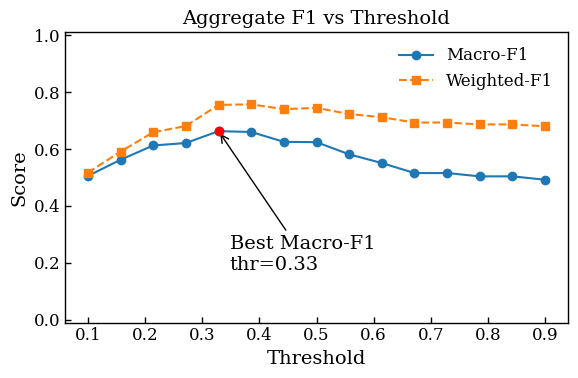

In [30]:
best_idx = report_df["MacroF1"].idxmax()
thr_best = report_df.loc[best_idx, "Threshold"]
val_best = report_df.loc[best_idx, "MacroF1"]

plt.figure(figsize=(6,4))
plt.plot(report_df["Threshold"], report_df["MacroF1"], "o-", label="Macro-F1")
plt.plot(report_df["Threshold"], report_df["WeightedF1"], "s--", label="Weighted-F1")
plt.scatter(thr_best, val_best, color="red", zorder=5)
plt.annotate(f"Best Macro-F1\nthr={thr_best:.2f}", (thr_best, val_best), xytext=(8,-100),
             textcoords="offset points", arrowprops=dict(arrowstyle="->"))
plt.ylim(-0.01,1.01); plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Aggregate F1 vs Threshold"); plt.legend(frameon=False)
plt.tight_layout(); plt.savefig(os.path.join(figdir,"macro_weighted_f1_vs_threshold.png"), dpi=200, bbox_inches="tight"); plt.show()

- Low thresholds (~0.1–0.3): Many Alive are misclassified (false positives), but most Dead are captured (high sensitivity, low specificity).
- Higher thresholds (~0.5+): Fewer Alive are misclassified, but more Dead are missed (lower sensitivity, higher specificity).

**This highlights the sensitivity–specificity trade-off directly on the distribution.**

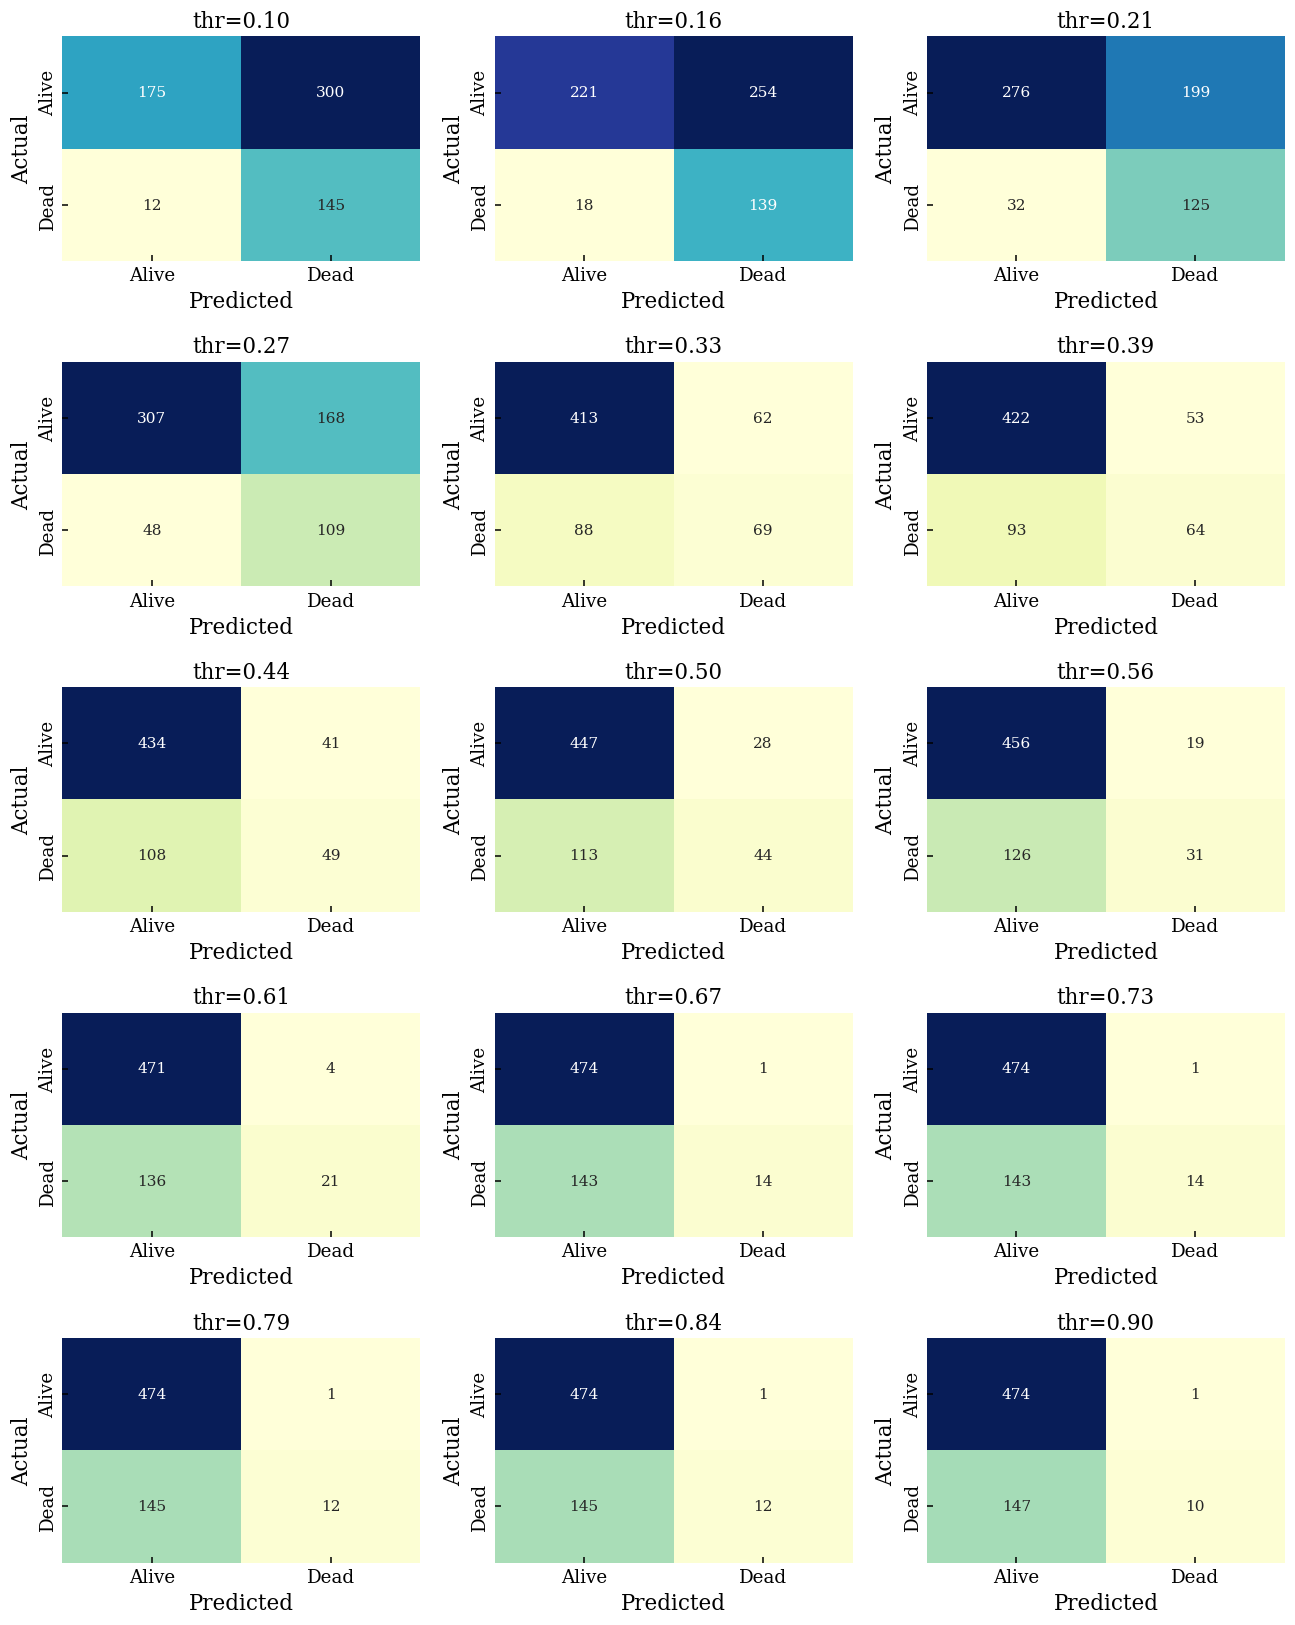

In [31]:
# Confusion matrices grid
n = len(report_df); cols = 3; rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), dpi=110)
axes = np.array(axes).reshape(-1)
for ax, (_, r) in zip(axes, report_df.iterrows()):
    cm = np.array([[r["TN"], r["FP"]],[r["FN"], r["TP"]]], dtype=int)
    cm_df = pd.DataFrame(cm, index=["Alive","Dead"], columns=["Alive","Dead"])
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=ax, annot_kws={"size":10})
    ax.set_title(f"thr={r['Threshold']:.2f}"); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for ax in axes[n:]:
    ax.axis("off")
plt.tight_layout(); plt.savefig(os.path.join(figdir,"confusion_matrices_by_threshold.png"), dpi=200, bbox_inches="tight"); plt.show()

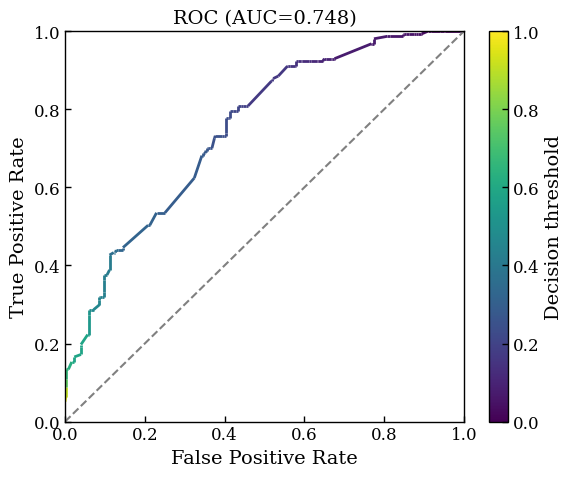

In [32]:
# ROC with threshold-encoded color
import matplotlib.colors as mcolors

fpr, tpr, thr_all = roc_curve(y_test, y_prob_cal)
mask = np.isfinite(thr_all)
x = fpr[mask]; y = tpr[mask]; z = np.clip(thr_all[mask], 0, 1)
points   = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm     = mcolors.Normalize(vmin=0.0, vmax=1.0)
cmap     = plt.cm.viridis
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(z[:-1]); lc.set_linewidth(2)
fig, ax = plt.subplots(figsize=(6,5))
ax.add_collection(lc); ax.plot([0,1],[0,1], "--", color="gray")
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC (AUC={roc_auc_score(y_test, y_prob_cal):.3f})")
cbar = fig.colorbar(lc, ax=ax); cbar.set_label("Decision threshold")
plt.tight_layout(); plt.savefig(os.path.join(figdir,"roc_colored_by_threshold.png"), dpi=200, bbox_inches="tight"); plt.show()


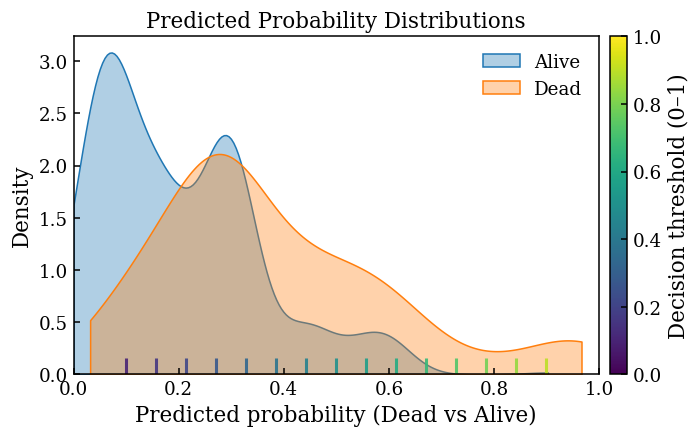

In [33]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(6.6, 4.2), dpi=110)

# KDEs
sns.kdeplot(y_prob_cal[y_test==0], fill=True, alpha=0.35, label="Alive",
            ax=ax, bw_method="scott", clip=(0,1), cut=0)
sns.kdeplot(y_prob_cal[y_test==1], fill=True, alpha=0.35, label="Dead",
            ax=ax, bw_method="scott", clip=(0,1), cut=0)

# Axes labels & limits
ax.set_xlim(0,1)
ax.set_xlabel("Predicted probability (Dead vs Alive)")
ax.set_ylabel("Density")
ax.set_title("Predicted Probability Distributions")

# Threshold markers + colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)          
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02, fraction=0.05)
cbar.set_label("Decision threshold (0–1)")       
cbar.set_ticks(np.linspace(0,1,6))                
cbar.ax.set_yticklabels([f"{t:.1f}" for t in np.linspace(0,1,6)])

# Threshold ticks on plot
ymin, ymax = ax.get_ylim()
h = ymin + 0.05*(ymax - ymin)
for t in thresholds:
    ax.vlines(t, ymin, h, color=cmap(norm(t)), lw=2, alpha=0.9)

ax.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(figdir,"density_with_threshold_ticks.png"),
            dpi=200, bbox_inches="tight")
plt.show()


In [34]:
# -------------------------
# Decision Curve Analysis (Net Benefit) + bootstrap CI
# -------------------------
def net_benefit(y_true, y_prob, pt):
    y_pred = (y_prob >= pt).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    n = len(y_true)
    return (tp/n) - (fp/n)*(pt/(1-pt))

pts = np.linspace(0.01, 0.80, 100)
nb_model = np.array([net_benefit(y_test, y_prob_cal, t) for t in pts])

n_boot = 1000; rng = np.random.RandomState(SEED)
boot_mat = np.empty((n_boot, len(pts)))
for i in range(n_boot):
    idx = rng.choice(len(y_test), size=len(y_test), replace=True)
    y_b = y_test.iloc[idx]; p_b = y_prob_cal[idx]
    boot_mat[i,:] = [net_benefit(y_b, p_b, t) for t in pts]
low, high = np.percentile(boot_mat, [2.5, 97.5], axis=0)

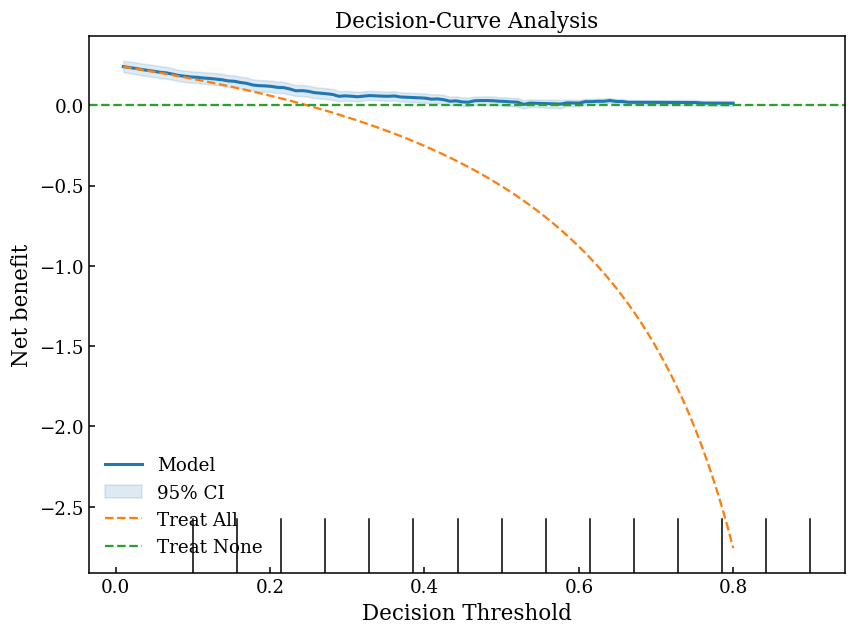

In [35]:
pi = y_test.mean()
nb_all  = pi - (1 - pi) * (pts / (1 - pts))
nb_none = np.zeros_like(pts)

plt.figure(figsize=(8,6), dpi=110)
plt.plot(pts, nb_model, lw=2, label="Model", color="C0")
plt.fill_between(pts, low, high, color="C0", alpha=0.15, label="95% CI")
plt.plot(pts, nb_all, "--", color="C1", label="Treat All")
plt.axhline(0, ls="--", color="C2", label="Treat None")
for t in thresholds:
    plt.axvline(t, ymin=0, ymax=0.1, color="black", lw=1)
plt.xlabel("Decision Threshold"); plt.ylabel("Net benefit")
plt.title("Decision-Curve Analysis"); plt.legend(loc="lower left", frameon=False)
plt.tight_layout(); plt.savefig(os.path.join(figdir,"decision_curve.png"), dpi=200, bbox_inches="tight"); plt.show()

- Shows net clinical benefit vs threshold.
- The model curve lies slightly above “treat none” for thresholds between ~0.1–0.5, meaning it offers modest value in that range.
- Beyond 0.6–0.7, the curve flattens → no net benefit compared to default strategies.
- “Treat all” has strongly negative net benefit at higher thresholds (as expected).

**How does it relate with density and confusion matrices???**
- The density plot showed predictive overlap in 0.2–0.5.
- The confusion matrices confirmed that sensitivity–specificity trade-offs are most active in this zone.
- Outside this zone (e.g. threshold >0.7), both the density and the confusion matrices showed almost no Dead are captured → and the decision curve shows no added net benefit.


In [36]:
# Print FP/FN table at evaluated thresholds (helps interpret DCA ticks)
summary_df = report_df[["Threshold","FP","FN"]].copy()
summary_df.columns = ["thr","FP","FN"]
print("\nFP/FN at evaluated thresholds:\n", summary_df.to_string(index=False))


FP/FN at evaluated thresholds:
      thr  FP  FN
0.100000 300  12
0.157143 254  18
0.214286 199  32
0.271429 168  48
0.328571  62  88
0.385714  53  93
0.442857  41 108
0.500000  28 113
0.557143  19 126
0.614286   4 136
0.671429   1 143
0.728571   1 143
0.785714   1 145
0.842857   1 145
0.900000   1 147


#### **In Summary**
- Model provides some discriminative power, but not strong separation.
- Thresholds around 0.2–0.5 are the “actionable zone” where there’s a meaningful balance between sensitivity and specificity.
- Thresholds too low → lots of false alarms. Thresholds too high → miss almost all Dead.
- Decision curve analysis confirms: the model has modest clinical utility in the low–mid threshold range, but no benefit beyond ~0.6

## **Survival Analysis on Optimized Threshold**

In [37]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

In [38]:
opt_thr = 0.33
margin  = 0.05

def stratify(p):
    if p < opt_thr - margin:      # < 0.28
        return "Low"
    elif p > opt_thr + margin:    # > 0.38
        return "High"
    else:                         # 0.28–0.38
        return "Medium"
    
# p_dead is the calibrated predicted probability on TEST
test["p_dead"] = pd.Series(y_prob_cal, index=test.index)
test["risk_group"] = test["p_dead"].apply(stratify)

In [39]:
# --- Ensure we have the predicted probabilities column name ---
if "p_dead" not in test and "y_prob_cal" in test:
    test["p_dead"] = test["y_prob_cal"]
# --- Clean FollowUp and create event indicator ---
test["FollowUp_num"] = pd.to_numeric(test["FollowUp"], errors="coerce")  # turns '--' into NaN
test["event"] = np.where(test["Outcome"]=="Dead", 1,
                 np.where(test["Outcome"]=="Alive", 0, np.nan))

# ---  Filter to valid survival rows (no NaNs in durations/event/group) ---
valid_mask = (
    test["FollowUp_num"].notna() &
    test["event"].notna() &
    test["risk_group"].notna()
)
print("Dropped rows:", (~valid_mask).sum())
test_surv = test.loc[valid_mask, ["FollowUp_num","event","risk_group","p_dead"]].copy()
test_surv.rename(columns={"FollowUp_num":"FollowUp"}, inplace=True)

test_surv = test_surv[test_surv["FollowUp"] > 0]

# --- sanity checks (means should be Low < Medium < High) ---
print("\nMean p_dead by group:")
print(test_surv.groupby("risk_group")["p_dead"].mean().round(3))
print("\nCounts by group:")
print(test_surv["risk_group"].value_counts().sort_index())

Dropped rows: 150

Mean p_dead by group:
risk_group
High      0.604
Low       0.108
Medium    0.303
Name: p_dead, dtype: float64

Counts by group:
risk_group
High       79
Low       314
Medium     82
Name: count, dtype: int64


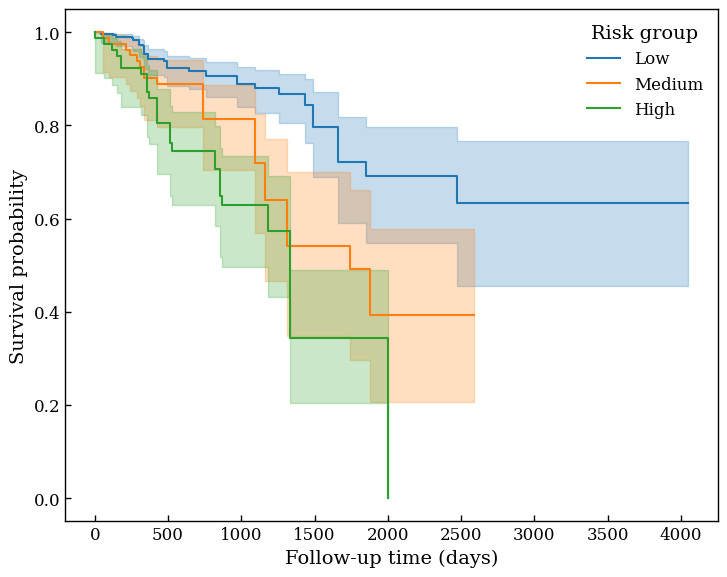

In [40]:
order = [g for g in ["Low","Medium","High"] if g in test_surv["risk_group"].unique()]
kmf = KaplanMeierFitter()
plt.figure(figsize=(7.5,6))

for grp in order:
    d = test_surv[test_surv["risk_group"]==grp]
    kmf.fit(d["FollowUp"], event_observed=d["event"], label=grp)
    kmf.plot(ci_show=True)

plt.xlabel("Follow-up time (days)")
plt.ylabel("Survival probability")
plt.legend(title="Risk group", frameon=False)
plt.tight_layout()
plt.show()

In [41]:
present = set(order)
if present == {"Low","High"}:
    dL = test_surv[test_surv["risk_group"]=="Low"]
    dH = test_surv[test_surv["risk_group"]=="High"]
    res = logrank_test(dL["FollowUp"], dH["FollowUp"], event_observed_A=dL["event"], event_observed_B=dH["event"])
    print("\nLog-rank Low vs High:")
    print(res.summary)
else:
    res = multivariate_logrank_test(test_surv["FollowUp"], test_surv["risk_group"], test_surv["event"])
    print("\nMultigroup log-rank (Low/Medium/High):")
    print(res.summary)


Multigroup log-rank (Low/Medium/High):
   test_statistic             p   -log2(p)
0       46.227249  9.159684e-11  33.345911


Extremely significant separation. The survival distributions of Low, Medium, and High risk groups are statistically different.

In [42]:
# ---  Cox proportional hazards to quantify effect ---
from lifelines import CoxPHFitter
test_surv["risk_group"] = pd.Categorical(test_surv["risk_group"], categories=["Low","Medium","High"], ordered=True)
cox_df = pd.get_dummies(test_surv[["FollowUp","event","risk_group"]], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col="FollowUp", event_col="event")
print("\nCox model (baseline=Low):")
cph.print_summary()


Cox model (baseline=Low):


<lifelines.CoxPHFitter: fitted with 475 total observations, 372 right-censored observations>
             duration col = 'FollowUp'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 475
number of events observed = 103
   partial log-likelihood = -518.66
         time fit was run = 2025-09-02 09:25:55 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
risk_group_Medium  0.84      2.32      0.26            0.32            1.35                1.38                3.87
risk_group_High    1.48      4.39      0.23            1.03            1.92                2.81                6.84

                   cmp to    z      p  -log2(p)
covariate                                      
risk_group_Medium    0.00 3.20 <0.005      9.50
risk_group_High      0.00 6.52 <0.005     33.68
---
Concordance = 0.64
Partial AIC = 1041.32
log-likelihood ratio test = 42.04 on 2 df
-log2(p) of ll-ratio test = 30.32

In [43]:
time_points = [0, 1000, 2000, 3000, 4000]          # rows
group_order = ["Low", "Medium", "High"]            # columns & order
group_colors = {"Low": "C0", "Medium": "C1", "High": "C2"}  # blue, orange, green
save_path = None  # e.g. r"C:\...\KM_risk_table_only.png" or leave None

# --- prepare data (expects test with columns: FollowUp, Outcome, risk_group) ---
df = test.copy()
df["FollowUp"] = pd.to_numeric(df["FollowUp"], errors="coerce")
df = df.dropna(subset=["FollowUp", "Outcome", "risk_group"])

# safety: keep only desired groups in desired order
df = df[df["risk_group"].isin(group_order)].copy()
df["risk_group"] = pd.Categorical(df["risk_group"], categories=group_order, ordered=True)

# --- compute counts at risk: those with FollowUp >= t (right-censored KM convention) ---
risk_counts = {
    grp: [(d["FollowUp"] >= t).sum() for t in time_points]
    for grp, d in df.groupby("risk_group", observed=True)
}
risk_df = pd.DataFrame(risk_counts, index=time_points)[group_order]
risk_df

,Low,Medium,High
0,320,82,80
1000,110,30,27
2000,18,5,7
3000,5,0,0
4000,2,0,0


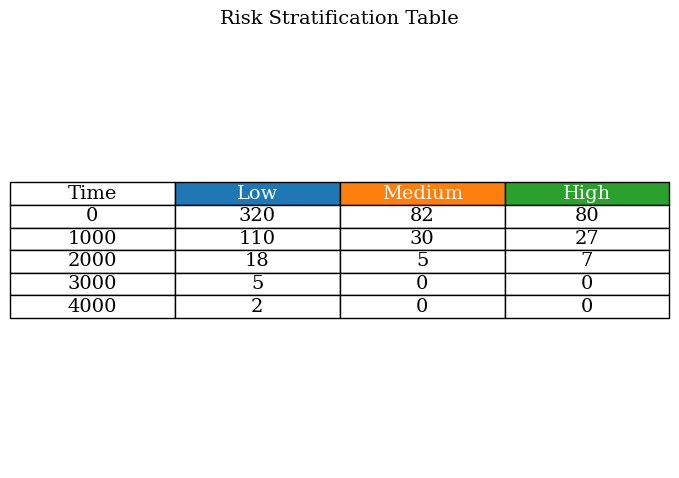

In [44]:
time_points = [0, 1000, 2000, 3000, 4000]
group_order = ["Low", "Medium", "High"]
group_colors = {"Low": "C0", "Medium": "C1", "High": "C2"}
risk_df_reset = risk_df.reset_index()
risk_df_reset.rename(columns={"index": "Time"}, inplace=True)


fig, ax = plt.subplots(figsize=(7,5))  # square canvas
ax.axis("off")
table = ax.table(
    cellText=risk_df_reset.values,
    colLabels=risk_df_reset.columns,
    cellLoc="center",
    rowLoc="center",
    loc="center"
)

# Color only the risk group headers (Low, Medium, High)
for j, grp in enumerate(group_order, start=1):  
    table[(0, j)].set_facecolor(group_colors[grp])
    table[(0, j)].get_text().set_color("white")  # white text for contrast

# Beautify
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

plt.title("Risk Stratification Table")
plt.tight_layout()
plt.show()